In [17]:
import pickle#引入pickle库 实现文本文件与二进制文件之间转化
#pt1 转换数据
data=[]#定义data列表 以便后面保存嵌套列表
with open("class2/ML100k.data","r") as file:
    for line in file:#对数据逐行迭代
        u_id,f_id,rate,time = map(int,line.strip().split())#将每一行的字符串去除杂乱符号并分割 分割后分别赋值给四个变量
        #尝试使用新学会的strip和split默认参数用法：不传参则去掉默认符号，按字符串分割
        data.append([u_id,f_id,rate,time])#将四个变量作为一维数组传入data数组中，作为第一条数据（data可视为二维数组）
print(f"前10条：{data[:10]}")#测试数据

with open("class2/data.pickle","wb")as file:
    pickle.dump(data,file)#将处理好的数据转化为二进制存入pickle文件

#pt2 过滤数据 （目标：1/删除少于五个电影评分的不活跃用户 2/删除被少于5个用户评分的冷门电影）
def filter(data,key=5):
    while(True):
        #统计用户评价次数和电影被评价次数
        user_count ={}#通过字典（key-value对应 用户-对应值）模拟计数器
        film_count ={}
        for u_id,f_id,rate,time in data:#对data中的每行数据迭代 并拆包赋值给四个变量
            user_count[u_id] = user_count.get(u_id,0)+1#如果user_count存在u_id这个key，则更新value为对应的value+1
            film_count[f_id] = film_count.get(f_id,0)+1#逻辑同上
        new_data =[]#定义新列表，记录统计之后的新数据
        #筛选数据(逐行迭代，如果用户评分次数和电影被评分次数同时大于key则存入新数据)
        for u_id,f_id,rate,time in data:
            if user_count[u_id] >=key and film_count[f_id] >=key:
                new_data.append([u_id,f_id,rate,time])
        #这里会发现存在一个很难受的bug：当某些数据被删除后，会导致某些电影的被评价次数降低，这样的话依旧不符合要求；同理也会造成某些用户评价次数降低
        #所以需要不断迭代，直到新数据和处理前数据相同：表明数据已经稳定
        if len(new_data) ==len(data):
            break;
        data = new_data
    return data

#对我们的数据使用我们定义的函数进行处理
f_data =filter(data,5)
print(f"过滤后的数据共有：{len(f_data)}条")

#pt3 统计数据
#统计指标：
#一 1/用户数量 2/电影数量 3/评分数量 二 1/稀疏度：评分数量/（用户数*电影数）） 
#三 1/某用户的平均评分(从小到大排序) 2/某个电影的平均评分（从小到大排序） 3/全部评分的平均评分
#四 统计所有评分中1-5分的分布情况（每个分数有多少条评分记录）
#五 将用户和电影分别重新从0标号
    user = sorted(set(u_id for u_id,_,_,_ in data))# set是无序列表，可以去重 通过sorted函数对去重后的id进行升序排序
    film = sorted(set(f_id for _,f_id,_,_ in data))
    rating= [rate for _,_,rate,_ in data]#评分并不需要去重
    u_sum = len(user)
    f_sum = len(film)
    r_sum = len(rating)
    sparsity = r_sum/(f_sum*u_sum)
    #第一二部分处理完成
    user_avgr ={}
    u_count =0
    f_avgr ={}
    f_count =0
    r_count =0
    for u in user:#使用去重后的用户列表进行迭代
        for u_id,_,r,_ in data if u_id ==u:
            u_count =u_count+1
        u_avgr[u] = [(u_acgr.get(u,0)+r)/u_count for u_id,_,r,_ in data if u_id ==u]#对data中的数据逐行迭代，如果用户_id和我们迭代的u相同，则将将u的value+r
    for f in film:
        for _,f_id,r,_ in data if f_id ==f:
            f_count =f_count+1
        f_avgr[f] = [(f_avgr.get(u,0))f_count+r for _,f_id,r,_ in data if f_id ==f]
    for r in rating:
        r_count+=r
    r_avg=r_count/r_sum
    #第三部分处理完成
    rate_level={1:0,2:0,3:0,4:0,5:0}
    for r in rating:
        rate_level[r]=rate_level.get(r,0)+1
    #第四部分处理完成
    new_u_count = 0
    new_f_count = 0
    new_user ={}
    new_film ={}
    for u in user:
        new_user[new_u_count]=u
        new_u_count+=1
    for f in film:
        new_film[new_f_count]=f
        new_f_count+=1
    #第五部分处理完成
    

IndentationError: unexpected indent (<ipython-input-17-f19217ad2443>, line 45)

Running experiments: 100%|██████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 641.18it/s]


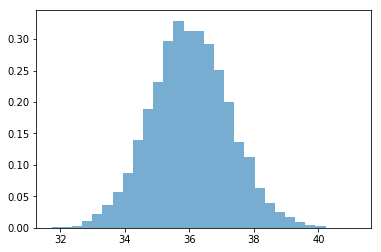

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk 统计量: 0.999517023563385
p 值: 0.009410574100911617


In [2]:
# 1. 导入所需库
import numpy as np  # 数值计算库，用于生成随机数、数组操作等
import matplotlib.pyplot as plt  # 绘图库，用于绘制误差分布直方图
from tqdm import tqdm  # 进度条库，让循环过程更直观（大循环时看进度很方便）
from sklearn.linear_model import LinearRegression  # 线性回归模型，用于拟合数据
from sklearn.metrics import mean_squared_error  # 均方误差函数，评估模型预测误差
from scipy.stats import shapiro  # Shapiro-Wilk 检验，用于判断数据是否符合正态分布

# 2. 定义生成**训练数据**的函数
def generate_data(n_samples):
    # 生成特征 X：均值为 0、标准差为 1 的正态分布随机数，形状是 (n_samples, 1)
    X = np.random.normal(0, 1, (n_samples, 1))
    # 生成标签 y：真实关系是 “y = 3X + 噪声”，噪声也是正态分布（均值 0、标准差 1）
    y = 3 * X + np.random.normal(0, 1, (n_samples, 1))
    return X, y  # 返回生成的训练特征和标签

# 3. 定义生成**测试数据**的函数
def generate_data_test(n_samples):
    # 生成特征 X：同样是均值 0、标准差 1 的正态分布（和训练集 X 分布一致，保证可比性）
    X = np.random.normal(0, 1, (n_samples, 1))
    # 生成标签 y：真实关系是 “y = 3X²”（二次关系，用来测试**线性模型**的泛化能力）
    y = 3 * X ** 2
    return X, y  # 返回生成的测试特征和标签

# 4. 定义“训练模型并计算误差”的函数
def calculate_error(X_train, X_test, y_train, y_test):
    model = LinearRegression()  # 实例化线性回归模型
    model.fit(X_train, y_train)  # 用训练数据拟合模型（学“y=3X+噪声”的线性规律）
    
    y_train_p = model.predict(X_train)  # 用模型预测**训练集**结果（看拟合效果）
    y_test_p = model.predict(X_test)    # 用模型预测**测试集**结果（看泛化效果）
    
    t_error = mean_squared_error(y_train, y_train_p)  # 计算训练集均方误差
    g_error = mean_squared_error(y_test, y_test_p)    # 计算测试集均方误差
    return t_error, g_error  # 返回训练误差、测试误差

# 5. 实验参数设置
n_samples = 10000  # 每个数据集的样本数量
n_exp = 10000      # 重复实验的次数（多次实验看误差的“分布规律”）
g_errors = []      # 用于存储每次实验的**测试误差**

# 6. 重复实验循环（tqdm包裹循环，显示进度条）
for _ in tqdm(range(n_exp), desc="Running experiments"):
    X, y = generate_data(n_samples)        # 生成1次训练数据
    X_test, y_test = generate_data_test(n_samples)  # 生成1次测试数据
    t_error, g_error = calculate_error(X, X_test, y, y_test)  # 计算本次的训练、测试误差
    g_errors.append(g_error)  # 把本次测试误差存入列表

# 7. 可视化测试误差的分布
plt.hist(g_errors, bins=30, density=True, alpha=0.6)  # 绘制直方图（bins=分箱数；density=密度模式；alpha=透明度）
plt.show()  # 显示图形

# 8. 正态性检验（Shapiro-Wilk 检验，判断误差是否符合正态分布）
stat, p = shapiro(g_errors)
print("Shapiro-Wilk 统计量:", stat)
print("p 值:", p)

In [ ]:
import pickle#引入pickle库 实现文本文件与二进制文件之间转化
#pt1 转换数据
data=[]#定义data列表 以便后面保存嵌套列表
with open("class2/ML100k.data","r") as file:
    for line in file:#对数据逐行迭代
        u_id,f_id,rate,time = map(int,line.strip().split())#将每一行的字符串去除杂乱符号并分割 分割后分别赋值给四个变量
        #尝试使用新学会的strip和split默认参数用法：不传参则去掉默认符号，按字符串分割
        data.append([u_id,f_id,rate,time])#将四个变量作为一维数组传入data数组中，作为第一条数据（data可视为二维数组）
print(f"前10条：{data[:10]}")#测试数据

with open("class2/data.pickle","wb")as file:
    pickle.dump(data,file)#将处理好的数据转化为二进制存入pickle文件

#pt2 过滤数据 （目标：1/删除少于五个电影评分的不活跃用户 2/删除被少于5个用户评分的冷门电影）
def filter(data,key=5):
    while(True):
        #统计用户评价次数和电影被评价次数
        user_count ={}#通过字典（key-value对应 用户-对应值）模拟计数器
        film_count ={}
        for u_id,f_id,rate,time in data:#对data中的每行数据迭代 并拆包赋值给四个变量
            user_count[u_id] = user_count.get(u_id,0)+1#如果user_count存在u_id这个key，则更新value为对应的value+1
            film_count[f_id] = film_count.get(f_id,0)+1#逻辑同上
        new_data =[]#定义新列表，记录统计之后的新数据
        #筛选数据(逐行迭代，如果用户评分次数和电影被评分次数同时大于key则存入新数据)
        for u_id,f_id,rate,time in data:
            if user_count[u_id] >=key and film_count[f_id] >=key:
                new_data.append([u_id,f_id,rate,time])
        #这里会发现存在一个很难受的bug：当某些数据被删除后，会导致某些电影的被评价次数降低，这样的话依旧不符合要求；同理也会造成某些用户评价次数降低
        #所以需要不断迭代，直到新数据和处理前数据相同：表明数据已经稳定
        if len(new_data) ==len(data):
            break;
        data = new_data
    return data

#对我们的数据使用我们定义的函数进行处理
f_data =filter(data,5)
print(f"过滤后的数据共有：{len(f_data)}条")

#pt3 统计数据
#统计指标：
#一 1/用户数量 2/电影数量 3/评分数量 二 1/稀疏度：评分数量/（用户数*电影数）） 
#三 1/某用户的平均评分(从小到大排序) 2/某个电影的平均评分（从小到大排序） 3/全部评分的平均评分
#四 统计所有评分中1-5分的分布情况（每个分数有多少条评分记录）
#五 将用户和电影分别重新从0标号

def sta(data):
    # 第一二部分: 数量统计和稀疏度
    user_ids = sorted(list(set(u_id for u_id,_,_,_ in data)))# set是无序列表，可以去重 通过sorted函数对去重后的id进行升序排序
    film_ids = sorted(list(set(f_id for _,f_id,_,_ in data)))
    rating= [rate for _,_,rate,_ in data]#评分并不需要去重
    u_sum = len(user_ids)
    f_sum = len(film_ids)
    r_sum = len(rating)
    sparsity = r_sum/(f_sum*u_sum)
    #第一二部分处理完成
    user_rating_sums = {}
    user_rating_counts = {}
    film_rating_sums = {}
    film_rating_counts = {}
    total_rating_sum = 0
    
    # 修正后的第三部分：使用一次遍历统计评分总和和次数
    for u_id, f_id, rate, _ in data:
        user_rating_sums[u_id] = user_rating_sums.get(u_id, 0) + rate
        user_rating_counts[u_id] = user_rating_counts.get(u_id, 0) + 1
        film_rating_sums[f_id] = film_rating_sums.get(f_id, 0) + rate
        film_rating_counts[f_id] = film_rating_counts.get(f_id, 0) + 1
        total_rating_sum += rate
    
    user_avg_ratings = {u_id: user_rating_sums[u_id] / user_rating_counts[u_id] for u_id in user_rating_sums}
    film_avg_ratings = {f_id: film_rating_sums[f_id] / film_rating_counts[f_id] for f_id in film_rating_sums}
    all_rating_avg = total_rating_sum / r_sum
    #第三部分处理完成

    rate_level={1:0,2:0,3:0,4:0,5:0}
    for r in rating:
        rate_level[r]=rate_level.get(r,0)+1
    #第四部分处理完成

    # 修正后的第五部分：创建旧ID到新ID的映射
    user_map = {}
    new_u_count = 0
    for u_id in user_ids:
        user_map[u_id] = new_u_count
        new_u_count += 1
    
    film_map = {}
    new_f_count = 0
    for f_id in film_ids:
        film_map[f_id] = new_f_count
        new_f_count += 1

    # 根据映射生成新的数据集
    reindexed_data = []
    for u_id, f_id, rate, time in data:
        new_u_id = user_map[u_id]
        new_f_id = film_map[f_id]
        reindexed_data.append([new_u_id, new_f_id, rate, time])
    #第五部分处理完成

    #测试
    print("---")
    print("## 统计结果")
    print(f"用户数量: {u_sum}")
    print(f"电影数量: {f_sum}")
    print(f"评分数量: {r_sum}")
    print(f"数据稀疏度: {sparsity:.6f}")
    
    print("\n用户平均评分(前10):")
    sorted_user_avg = sorted(user_avg_ratings.items(), key=lambda item: item[1])
    for u, avg in sorted_user_avg[:10]:
        print(f"  用户 {u}: {avg:.2f}")

    print("\n电影平均评分(前10):")
    sorted_film_avg = sorted(film_avg_ratings.items(), key=lambda item: item[1])
    for f, avg in sorted_film_avg[:10]:
        print(f"  电影 {f}: {avg:.2f}")
    
    print(f"\n所有评分的平均评分: {all_rating_avg:.2f}")
    
    print("\n---")
    print("## 评分分布")
    for rate, count in sorted(rate_level.items()):
        print(f"  评分 {rate}: {count} 条记录")

    print("\n---")
    print("## 数据重新编号")
    print(f"原用户ID列表(前10): {user_ids[:10]}")
    print(f"新用户ID列表(前10): {[user_map[u] for u in user_ids[:10]]}")
    print(f"原电影ID列表(前10): {film_ids[:10]}")
    print(f"新电影ID列表(前10): {[film_map[f] for f in film_ids[:10]]}")
    print(f"重新编号后的数据(前10): {reindexed_data[:10]}")

    return reindexed_data

reindexed_f_data = sta(f_data)